# Machine Learning based Real-time American Sign Language Detection
### CS 6136 Machine Learning Project

### Team 32 - Ashish Gawali, Kalyanasundharam Kathiresan, Zoraiz Qureshi (afx2vc, kkl2rw, zce5py)


# Imports

In [1]:
%%bash
pip install keras-tuner --upgrade
pip install scikit-optimize
pip install visualkeras

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import keras
import os
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import trange, tqdm
import pickle
from skimage import filters

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score
from sklearn.model_selection import KFold, validation_curve, GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA
from scipy.stats import loguniform
from skopt import BayesSearchCV # didn't use
import visualkeras

from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
import keras_tuner as kt

# Training Helpers, Tuning Parameter Ranges

In [18]:
def get_tuning_parameters(clf, search_type):

    if search_type == 'random': # best for random search
        lr_tol_range = loguniform(1e-6, 100)
        lr_C_range = loguniform(1e-5, 100)
        svm_C_range = np.logspace(-3, 2, 6)
        svm_gamma_range = np.logspace(-3, 2, 6)

    elif search_type == 'grid':
        # for grid search
        lr_tol_range = [0.001, 0.01, 0.1, 1, 10, 100]
        lr_C_range = [0.001, 0.01, 0.1, 1, 10, 100]
        svm_C_range = [0.001, 0.01, 0.1, 1, 10, 100]
        # svm_gamma_range = ['scale', 'auto', 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
        svm_gamma_range = ['scale']

    
    general_lr_params = {
        # 'tol': lr_tol_range, 
        'C': lr_C_range, 
        # 'fit_intercept': [True, False], 
        # 'max_iter':[100, 200, 300]
    }

    PARAMETERS_LR = [
        {'solver': ['saga'],  'penalty': ['l1','l2'],  **general_lr_params},
        {'solver': ['saga'],  'penalty': ['elasticnet'], 'l1_ratio': np.linspace(0,1,10), **general_lr_params },
        {'solver': ['lbfgs', 'newton-cg'], 'penalty': ['none','l2'], **general_lr_params }
    ]


    PARAMETERS_SVM = [
        # {'kernel': ['linear', 'sigmoid'], 'C': svm_C_range},
        # {'kernel': ['poly'], 'degree': [1,2,3,4,5], 'C': svm_C_range, 'gamma': svm_gamma_range},
        {'kernel': ['rbf'], 'C': svm_C_range, 'gamma': svm_gamma_range},
    ]

    PARAMETERS_MLP = {
        'hidden_layer_sizes': [
                            [128, 64, 32, 16, 8], 
                            [128, 64, 32, 16], 
                            [32, 16, 8], 
                            [128, 64],
                            [128, 64, 32], 
                            [256, 128],
                            [64, 32],
                            [32, 32],
                            [32, 16], 
                            [8, 8], 
                            [16, 16],
                            [16, 8],
                            [8, 4],
                            8, 16, 32, 64, 128, 256
                            ], 
        'activation': ['logistic', 'tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'learning_rate_init': [1.0, 0.1, 0.01, 0.001, 0.0001],
        'batch_size': [16, 32, 64],
        'max_iter': [50, 100, 200, 250, 500]
    }

    if clf.__class__ == LogisticRegression:
        return PARAMETERS_LR
    elif clf.__class__ == SVC:
        return PARAMETERS_SVM
    elif clf.__class__ == MLPClassifier:
        return PARAMETERS_MLP




def evaluate(clf, x_train, y_train, x_test, y_test):
    train_score = clf.score(x_train, y_train)
    test_score = clf.score(x_test, y_test)

    print('train_score: ', train_score)
    print('test_score: ', test_score)

    y_pred = clf.predict(x_test)
    
    # indexes to alphabets
    class_lbls = [chr(c+65) for c in clf.classes_]
    
    # 29 classes for dataset 2
    if len(class_lbls) == 29:
        class_lbls[26] = 'SPACE'
        class_lbls[27] = 'DELETE'
        class_lbls[28] = 'NOTHING'


    cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels = clf.classes_)
    test_f1 = f1_score(y_true=y_test, y_pred=y_pred, average='macro')
    test_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
    print("Test F1 score: ", test_f1)
    print('Test Accuracy: ', test_accuracy)

    plt.figure(figsize=(12,12))
    sns.heatmap(cm, annot=True, linewidths=.5, square = True, fmt='', xticklabels=class_lbls, yticklabels=class_lbls)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

    print(classification_report(y_test, y_pred))

    return [train_score, test_score, test_f1, test_accuracy, cm]


def train_classifier(clf, x_train, y_train, x_test, y_test, tuning=False, search_type='random', CV_FOLDS = 3, RANDSEARCH_N_ITER = 20, parameters=None):
    clf.fit(x_train, y_train)

    metrics = evaluate(clf, x_train, y_train, x_test, y_test)

    if tuning:
        print("\n===================\nHYPERPARAMETER TUNING...")

        if parameters is None:
            parameters = get_tuning_parameters(clf, search_type)

        if search_type == 'grid':
            clf_cv = GridSearchCV(clf, parameters, cv=CV_FOLDS, verbose=3, scoring='f1_macro')
        elif search_type == 'random':
            clf_cv = RandomizedSearchCV(clf, parameters, cv=CV_FOLDS, n_iter=RANDSEARCH_N_ITER, verbose=3, scoring='f1_macro')
            # clf_cv = BayesSearchCV(clf, parameters, cv=CV_FOLDS, n_iter=RANDSEARCH_N_ITER, verbose=3, scoring='f1')
        else:
            print('Invalid search type.')
            return None
            
        clf_cv.fit(x_train, y_train)

        print("best params", clf_cv.best_params_)

        metrics = evaluate(clf_cv, x_train, y_train, x_test, y_test)

        clf = clf_cv

    with open('best_clf.pkl', 'wb') as f:
        pickle.dump(clf, f)

    return metrics


# MNIST Image Dataset

## Load Data


In [ ]:
%%bash
if [ ! -d "sign_mnist_test" ]
then
    echo '{"username":"zoraizq","key":"fc84a132b1366b775f79560a14cc911d"}' > kaggle.json
    cp "/content/kaggle.json" "/root/.kaggle/kaggle.json"
    chmod 600 /root/.kaggle/kaggle.json
    kaggle datasets download datamunge/sign-language-mnist
    unzip sign-language-mnist.zip
    mv sample_data/ ..
    mv sign-language-mnist.zip ..
else
    echo "Dataset folder already exists."
fi

if [ ! -d "sign_mnist_test" ]
then
    echo '{"username":"zoraizq","key":"fc84a132b1366b775f79560a14cc911d"}' > kaggle.json
    cp "/content/kaggle.json" "/root/.kaggle/kaggle.json"
    chmod 600 /root/.kaggle/kaggle.json
    kaggle datasets download datamunge/sign-language-mnist
    unzip sign-language-mnist.zip
    mv sample_data/ ..
    mv sign-language-mnist.zip ..
else
    echo "Dataset folder already exists."
fi

Dataset folder already exists.
Dataset folder already exists.


In [ ]:
train_df = pd.read_csv("./sign_mnist_train/sign_mnist_train.csv")
test_df = pd.read_csv("sign_mnist_test/sign_mnist_test.csv")

train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [ ]:
if 'label' in train_df:
    y_train = train_df['label']
    y_test = test_df['label']
    del train_df['label']
    del test_df['label']

x_train = train_df.values
x_test = test_df.values

split_point = x_train.shape[0]

# test is ~20%
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(27455, 784) (7172, 784) (27455,) (7172,)


GENERAL FEATURE SCALING, EXPLORATION

1.0


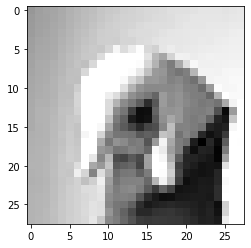

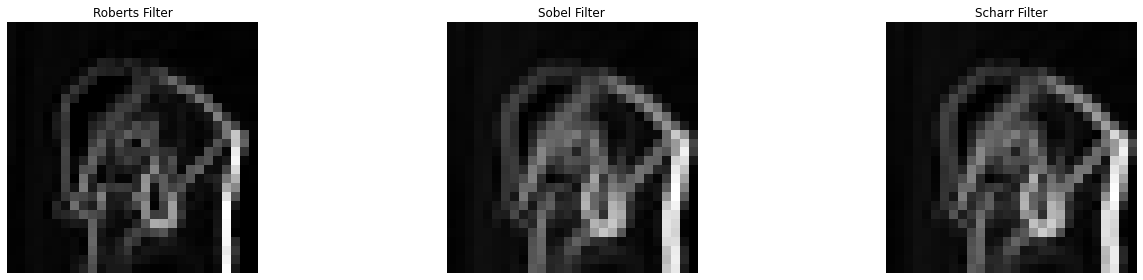

In [ ]:
# normalize / feature scaling - to speed up learning
if x_train.max() > 1:
  x_train = x_train / 255
  x_test = x_test / 255


print(x_train.max())

sample_image = x_train[5].reshape(28,28)
plt.figure(figsize=(4,4))
plt.imshow(sample_image, cmap = "gray")
plt.show()

## FILTERS
image = sample_image
edge_roberts = filters.roberts(image)
edge_sobel = filters.sobel(image)
edge_scharr = filters.scharr(image)

fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(20, 4))

axes[0].imshow(edge_roberts, cmap=plt.cm.gray)
axes[0].set_title('Roberts Filter')

axes[1].imshow(edge_sobel, cmap=plt.cm.gray)
axes[1].set_title('Sobel Filter')

axes[2].imshow(edge_scharr, cmap=plt.cm.gray)
axes[2].set_title('Scharr Filter')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

## Pre-Process and Data Generators


In [ ]:
def data_aug(x, y, aug_factor):
    # based on limited hand rotation, flip, shifts, zoom
    datagen_aug = ImageDataGenerator(
            rotation_range=30,
            horizontal_flip=True,
            brightness_range=[0.2,1.0],
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
        )

    # convert to img matrix and then rgb format for datagen
    x_img = x.reshape(-1,28,28)
    x_img = np.stack((x_img,)*3, axis=-1)

    aug_data_iterator = datagen_aug.flow(x=x_img, y=y, batch_size=1, seed=1)

    print('Data aug samples:')
    # show some
    for i in range(9):
        plt.subplot(330 + 1 + i)
        image, lbl = aug_data_iterator.next()
        image = image[0]
        lbl = lbl[0]
        image /= 255
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        plt.imshow(image, cmap='gray')
        plt.title(lbl)

    plt.show()


    x_aug = [] # include existing images
    y_aug = []

    new_samples = int(x_img.shape[0]*(aug_factor))

    print(new_samples)
    for i in trange(new_samples):
        image, lbl = aug_data_iterator.next()
        image = image[0]
        lbl = lbl[0]
        image /= 255
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        x_aug.append(image.flatten())
        y_aug.append(lbl)

    x_aug = np.concatenate([x_img[:,:,:,0].reshape(-1,784), x_aug])
    y_aug = np.concatenate([y, y_aug])

    print('Augmented final sizes:', x_aug.shape, y_aug.shape)

    return x_aug, y_aug

In [ ]:
filters_func = {'roberts': filters.roberts, 'sobel': filters.sobel, 'scharr': filters.scharr}

def gen_training_set(PCA_COMPONENTS, FILTER_NAME, FOR_CNN):
    global x_train
    global y_train
    global x_test
    global y_te

    x_tr = np.copy(x_train)
    x_te = np.copy(x_test)

    y_tr = np.copy(y_train)
    y_te = np.copy(y_test)

    # apply filter to all images
    if FILTER_NAME != '':
        print(f'Using the {FILTER_NAME} filter...')
        for i in range(x_tr.shape[0]):
            image = x_tr[i].reshape(28,28)
            image = filters_func[FILTER_NAME](image)
            x_tr[i] = image.reshape(784)

        for i in range(x_te.shape[0]):
            image = x_te[i].reshape(28,28)
            image = filters_func[FILTER_NAME](image)
            x_te[i] = image.reshape(784)

        # visualize first 6 images after filter app
        print('train')
        for i in range(6):
            plt.subplot(330 + 1 + i)
            plt.imshow(x_tr[i].reshape(28, 28) , cmap = "gray")
            plt.title(chr(y_tr[i]+65))
            plt.show()

    # DATA AUGMENTATION
    if FOR_CNN:   
        x_tr = x_tr.reshape(-1,28,28,1)
        x_te = x_te.reshape(-1,28,28,1)
        
        print('Final data sizes: ', x_tr.shape, x_te.shape, y_tr.shape, y_te.shape)
        return x_tr, x_te, y_tr, y_te 

    else:
        # use PCA for dimensionality reduction / feature selection
        if PCA_COMPONENTS != -1:
            pca_784 = PCA(n_components=784)
            pca_784.fit(x_tr)

            plt.grid()
            plt.plot(np.cumsum(pca_784.explained_variance_ratio_ * 100))
            plt.xlabel('Number of components')
            plt.ylabel('Explained variance')
            plt.savefig('scree-plot.png')
            plt.show()


            pca_red = PCA(n_components=PCA_COMPONENTS)
            x_tr = pca_red.fit_transform(x_tr) # fit and transform on training
            x_te = pca_red.transform(x_te) # transform test only

            x_tr_pca_recovered = pca_red.inverse_transform(x_tr)

            image_pca_red = x_tr_pca_recovered[5].reshape([28,28])
            plt.imshow(image_pca_red, cmap='gray_r')
            plt.title(f'Compressed image with {PCA_COMPONENTS} components', fontsize=15, pad=15)
            plt.plot()
            plt.show()

            print(np.cumsum(pca_red.explained_variance_ratio_ * 100)[-1])

        # normalize again because of the filters
        if x_tr.max() > 1:
            scaler = preprocessing.MinMaxScaler().fit(x_tr)
            x_tr = scaler.transform(x_tr)

            scaler = preprocessing.MinMaxScaler().fit(x_te)
            x_te = scaler.transform(x_te)

        print('Final data sizes: ', x_tr.shape, x_te.shape, y_tr.shape, y_te.shape)
        return x_tr, x_te, y_tr, y_te

## Training

In [ ]:
# DATA PREP HYPERPARAMETERS
'''
gen_training_set
    PCA_COMPONENTS = 50 # set to -1 to not do PCA
    FILTER_NAME # set to '' to not apply any filter, otherwise ['roberts', 'sobel', 'scharr']
    FOR_CNN = set to false to not generate 28, 28, 1 images
    AUG_FACTOR set to -1 to not do data aug, set to 2 to do 3-fold data aug (2/3 are augmented, 1/3 original)
'''

"\ngen_training_set\n    PCA_COMPONENTS = 50 # set to -1 to not do PCA\n    FILTER_NAME # set to '' to not apply any filter, otherwise ['roberts', 'sobel', 'scharr']\n    FOR_CNN = set to false to not generate 28, 28, 1 images\n    AUG_FACTOR set to -1 to not do data aug, set to 2 to do 3-fold data aug (2/3 are augmented, 1/3 original)\n"

### Logistic Regression

In [ ]:
x_tr, x_te, y_tr, y_te = gen_training_set(PCA_COMPONENTS=-1, FILTER_NAME='', FOR_CNN=False)

Final data sizes:  (27455, 784) (7172, 784) (27455,) (7172,)


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   17.4s finished


train_score:  0.9576397741759243
test_score:  0.675404350250976
Test F1 score:  0.6558385030408771
Test Accuracy:  0.675404350250976


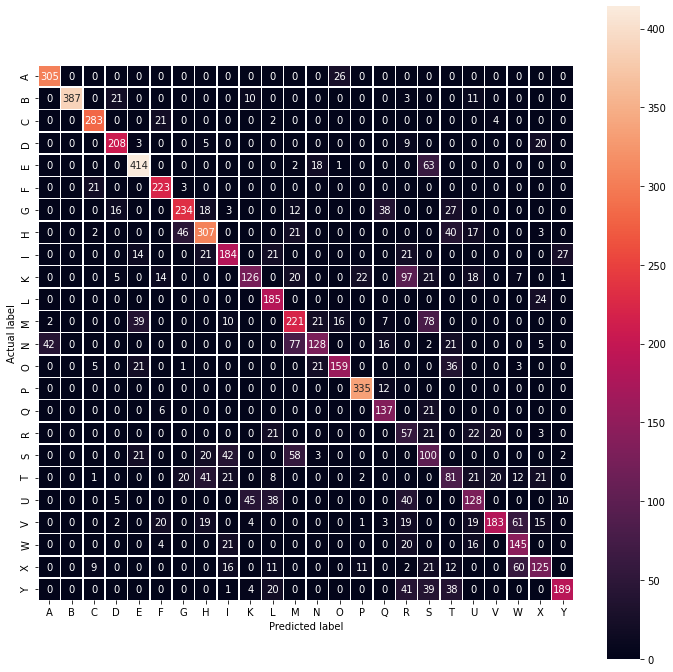

              precision    recall  f1-score   support

           0       0.87      0.92      0.90       331
           1       1.00      0.90      0.95       432
           2       0.88      0.91      0.90       310
           3       0.81      0.85      0.83       245
           4       0.81      0.83      0.82       498
           5       0.77      0.90      0.83       247
           6       0.77      0.67      0.72       348
           7       0.71      0.70      0.71       436
           8       0.62      0.64      0.63       288
          10       0.67      0.38      0.48       331
          11       0.60      0.89      0.72       209
          12       0.54      0.56      0.55       394
          13       0.67      0.44      0.53       291
          14       0.79      0.65      0.71       246
          15       0.90      0.97      0.93       347
          16       0.64      0.84      0.73       164
          17       0.18      0.40      0.25       144
          18       0.27    

In [ ]:
clf = LogisticRegression(verbose=1,n_jobs=10)

metrics_lr = train_classifier(clf, x_tr, y_tr, x_te, y_te, tuning=False)

Using the roberts filter...
train


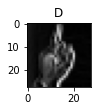

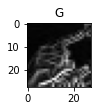

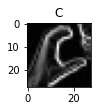

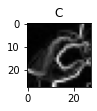

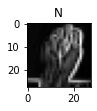

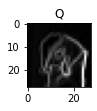

Final data sizes:  (27455, 784) (7172, 784) (27455,) (7172,)


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   17.8s finished


train_score:  0.9998178838098707
test_score:  0.6749860568878974
Test F1 score:  0.6614263832495105
Test Accuracy:  0.6749860568878974


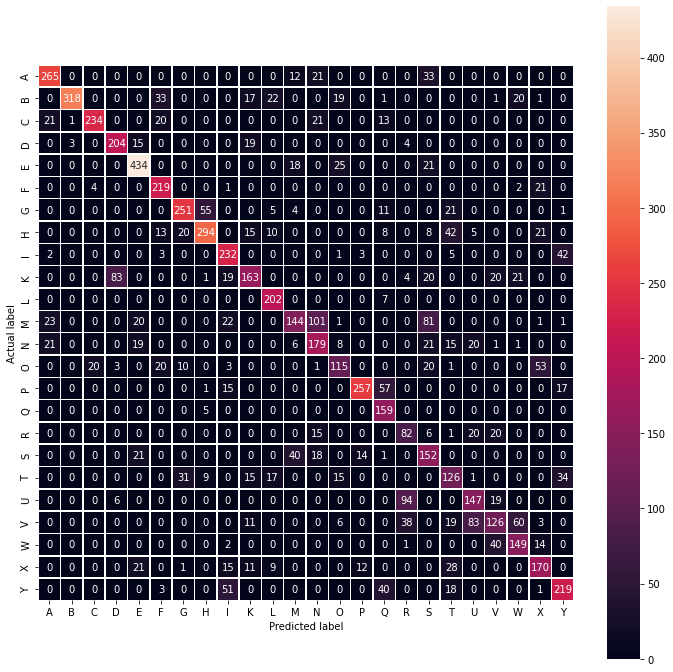

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       331
           1       0.99      0.74      0.84       432
           2       0.91      0.75      0.82       310
           3       0.69      0.83      0.75       245
           4       0.82      0.87      0.84       498
           5       0.70      0.89      0.78       247
           6       0.80      0.72      0.76       348
           7       0.81      0.67      0.73       436
           8       0.64      0.81      0.72       288
          10       0.65      0.49      0.56       331
          11       0.76      0.97      0.85       209
          12       0.64      0.37      0.47       394
          13       0.50      0.62      0.55       291
          14       0.61      0.47      0.53       246
          15       0.90      0.74      0.81       347
          16       0.54      0.97      0.69       164
          17       0.37      0.57      0.45       144
          18       0.42    

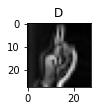

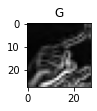

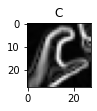

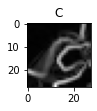

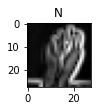

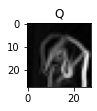

Final data sizes:  (27455, 784) (7172, 784) (27455,) (7172,)


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   17.0s finished


train_score:  1.0
test_score:  0.6759620747350809
Test F1 score:  0.660776998777342
Test Accuracy:  0.6759620747350809


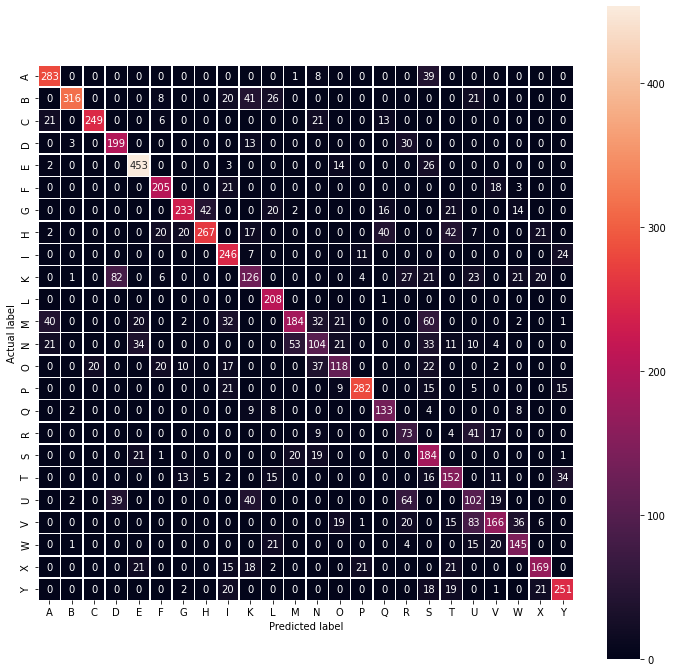

              precision    recall  f1-score   support

           0       0.77      0.85      0.81       331
           1       0.97      0.73      0.83       432
           2       0.93      0.80      0.86       310
           3       0.62      0.81      0.70       245
           4       0.83      0.91      0.87       498
           5       0.77      0.83      0.80       247
           6       0.83      0.67      0.74       348
           7       0.85      0.61      0.71       436
           8       0.62      0.85      0.72       288
          10       0.46      0.38      0.42       331
          11       0.69      1.00      0.82       209
          12       0.71      0.47      0.56       394
          13       0.45      0.36      0.40       291
          14       0.58      0.48      0.53       246
          15       0.88      0.81      0.85       347
          16       0.66      0.81      0.72       164
          17       0.33      0.51      0.40       144
          18       0.42    

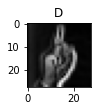

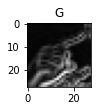

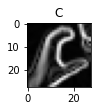

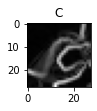

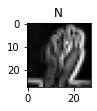

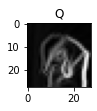

Final data sizes:  (27455, 784) (7172, 784) (27455,) (7172,)


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   17.1s finished


train_score:  1.0
test_score:  0.6756832124930284
Test F1 score:  0.6603443516650644
Test Accuracy:  0.6756832124930284


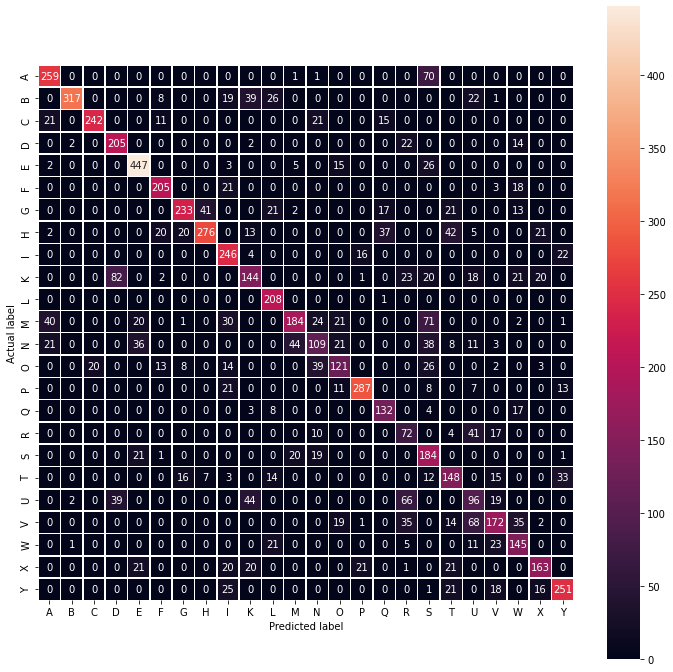

              precision    recall  f1-score   support

           0       0.75      0.78      0.77       331
           1       0.98      0.73      0.84       432
           2       0.92      0.78      0.85       310
           3       0.63      0.84      0.72       245
           4       0.82      0.90      0.86       498
           5       0.79      0.83      0.81       247
           6       0.84      0.67      0.74       348
           7       0.85      0.63      0.73       436
           8       0.61      0.85      0.71       288
          10       0.54      0.44      0.48       331
          11       0.70      1.00      0.82       209
          12       0.72      0.47      0.57       394
          13       0.49      0.37      0.42       291
          14       0.58      0.49      0.53       246
          15       0.88      0.83      0.85       347
          16       0.65      0.80      0.72       164
          17       0.32      0.50      0.39       144
          18       0.40    

In [ ]:
for filter in ['roberts', 'sobel', 'scharr']:
    x_tr, x_te, y_tr, y_te = gen_training_set(PCA_COMPONENTS=-1, FILTER_NAME=filter, FOR_CNN=False)

    clf = LogisticRegression(verbose=1,n_jobs=10)

    metrics_mlp = train_classifier(clf, x_tr, y_tr, x_te, y_te, tuning=False)

Final data sizes:  (27455, 784) (7172, 784) (27455,) (7172,)


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   17.6s finished


train_score:  0.9576397741759243
test_score:  0.675404350250976
Test F1 score:  0.6558385030408771
Test Accuracy:  0.675404350250976


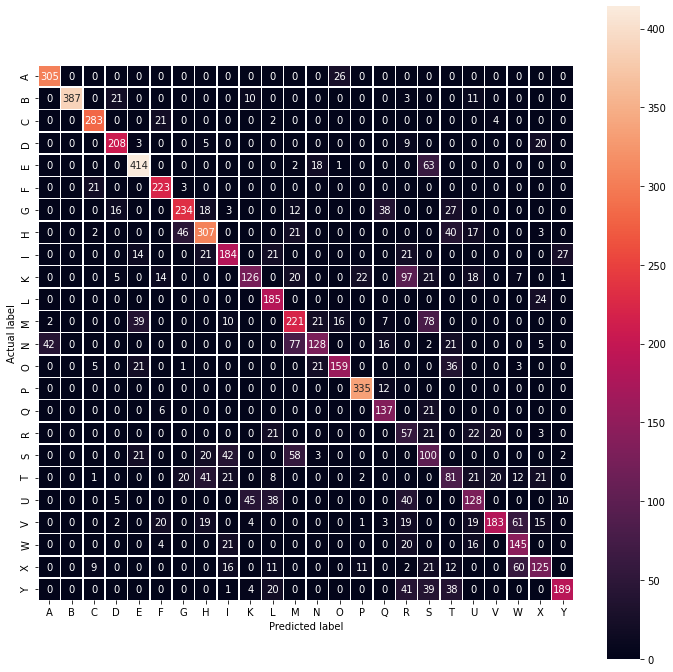

              precision    recall  f1-score   support

           0       0.87      0.92      0.90       331
           1       1.00      0.90      0.95       432
           2       0.88      0.91      0.90       310
           3       0.81      0.85      0.83       245
           4       0.81      0.83      0.82       498
           5       0.77      0.90      0.83       247
           6       0.77      0.67      0.72       348
           7       0.71      0.70      0.71       436
           8       0.62      0.64      0.63       288
          10       0.67      0.38      0.48       331
          11       0.60      0.89      0.72       209
          12       0.54      0.56      0.55       394
          13       0.67      0.44      0.53       291
          14       0.79      0.65      0.71       246
          15       0.90      0.97      0.93       347
          16       0.64      0.84      0.73       164
          17       0.18      0.40      0.25       144
          18       0.27    

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   17.1s finished


[CV 1/3] END C=0.0019016921614744382, l1_ratio=0.5555555555555556, penalty=elasticnet, solver=saga;, score=0.004 total time=  17.4s


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   13.3s finished


[CV 2/3] END C=0.0019016921614744382, l1_ratio=0.5555555555555556, penalty=elasticnet, solver=saga;, score=0.004 total time=  13.5s


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   15.2s finished


[CV 3/3] END C=0.0019016921614744382, l1_ratio=0.5555555555555556, penalty=elasticnet, solver=saga;, score=0.004 total time=  15.4s


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   10.2s finished


[CV 1/3] END C=0.0013332013471852623, penalty=l1, solver=saga;, score=0.004 total time=  10.4s


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   14.0s finished


[CV 2/3] END C=0.0013332013471852623, penalty=l1, solver=saga;, score=0.004 total time=  14.3s


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   14.0s finished


[CV 3/3] END C=0.0013332013471852623, penalty=l1, solver=saga;, score=0.004 total time=  14.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   11.7s finished


[CV 1/3] END C=0.00026917829979621353, penalty=none, solver=lbfgs;, score=0.944 total time=  11.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   11.7s finished


[CV 2/3] END C=0.00026917829979621353, penalty=none, solver=lbfgs;, score=0.946 total time=  11.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   12.4s finished


[CV 3/3] END C=0.00026917829979621353, penalty=none, solver=lbfgs;, score=0.952 total time=  12.6s


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:  2.4min finished


[CV 1/3] END C=1.0388238130732947, penalty=l2, solver=saga;, score=0.999 total time= 2.4min


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:  2.4min finished


[CV 2/3] END C=1.0388238130732947, penalty=l2, solver=saga;, score=0.999 total time= 2.4min


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:  2.4min finished


[CV 3/3] END C=1.0388238130732947, penalty=l2, solver=saga;, score=0.998 total time= 2.4min


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:  7.8min finished


[CV 1/3] END C=47.317418085605404, l1_ratio=0.6666666666666666, penalty=elasticnet, solver=saga;, score=0.999 total time= 7.8min


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 2/3] END C=47.317418085605404, l1_ratio=0.6666666666666666, penalty=elasticnet, solver=saga;, score=0.999 total time= 7.8min


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:  7.8min finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:  7.8min finished


[CV 3/3] END C=47.317418085605404, l1_ratio=0.6666666666666666, penalty=elasticnet, solver=saga;, score=0.999 total time= 7.8min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:  1.7min finished


[CV 1/3] END C=14.609261586375283, penalty=none, solver=newton-cg;, score=1.000 total time= 1.7min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:  1.8min finished


[CV 2/3] END C=14.609261586375283, penalty=none, solver=newton-cg;, score=1.000 total time= 1.8min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:  1.8min finished


[CV 3/3] END C=14.609261586375283, penalty=none, solver=newton-cg;, score=1.000 total time= 1.8min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:  1.8min finished


[CV 1/3] END C=0.0014348665688488666, penalty=none, solver=newton-cg;, score=1.000 total time= 1.8min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:  1.8min finished


[CV 2/3] END C=0.0014348665688488666, penalty=none, solver=newton-cg;, score=1.000 total time= 1.8min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:  1.9min finished


[CV 3/3] END C=0.0014348665688488666, penalty=none, solver=newton-cg;, score=1.000 total time= 1.9min


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:  2.5min finished


[CV 1/3] END C=0.07331277812206285, penalty=l2, solver=saga;, score=0.959 total time= 2.5min


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:  2.4min finished


[CV 2/3] END C=0.07331277812206285, penalty=l2, solver=saga;, score=0.964 total time= 2.5min


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:  2.5min finished


[CV 3/3] END C=0.07331277812206285, penalty=l2, solver=saga;, score=0.962 total time= 2.5min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:  1.7min finished


[CV 1/3] END C=0.0371625183188515, penalty=none, solver=newton-cg;, score=1.000 total time= 1.7min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:  1.8min finished


[CV 2/3] END C=0.0371625183188515, penalty=none, solver=newton-cg;, score=1.000 total time= 1.8min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:  1.9min finished


[CV 3/3] END C=0.0371625183188515, penalty=none, solver=newton-cg;, score=1.000 total time= 1.9min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   11.9s finished


[CV 1/3] END C=1.592352674890827e-05, penalty=none, solver=lbfgs;, score=0.944 total time=  12.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   11.4s finished


[CV 2/3] END C=1.592352674890827e-05, penalty=none, solver=lbfgs;, score=0.946 total time=  11.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   12.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV 3/3] END C=1.592352674890827e-05, penalty=none, solver=lbfgs;, score=0.952 total time=  12.4s


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:  3.0min finished


best params {'C': 14.609261586375283, 'penalty': 'none', 'solver': 'newton-cg'}
train_score:  1.0
test_score:  0.651007796953167
Test F1 score:  0.651007796953167
Test Accuracy:  0.6756832124930284


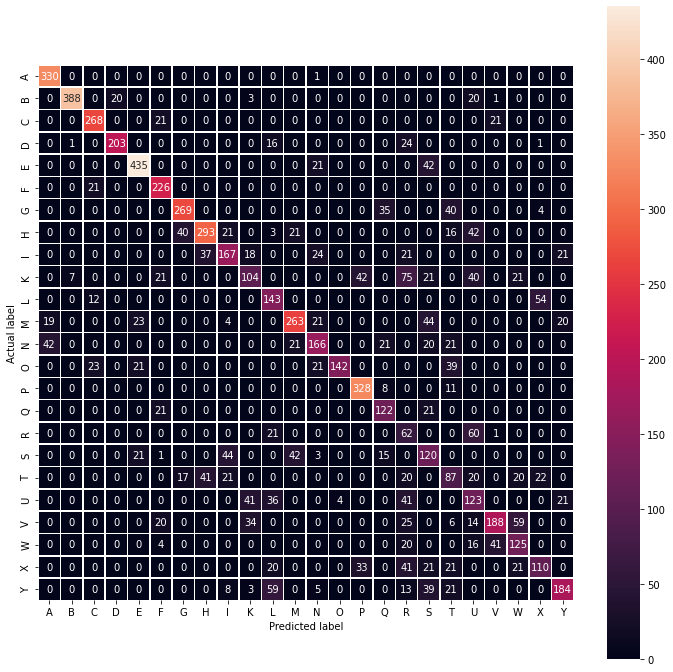

              precision    recall  f1-score   support

           0       0.84      1.00      0.91       331
           1       0.98      0.90      0.94       432
           2       0.83      0.86      0.85       310
           3       0.91      0.83      0.87       245
           4       0.87      0.87      0.87       498
           5       0.72      0.91      0.81       247
           6       0.83      0.77      0.80       348
           7       0.79      0.67      0.73       436
           8       0.63      0.58      0.60       288
          10       0.51      0.31      0.39       331
          11       0.48      0.68      0.56       209
          12       0.76      0.67      0.71       394
          13       0.63      0.57      0.60       291
          14       0.97      0.58      0.72       246
          15       0.81      0.95      0.87       347
          16       0.61      0.74      0.67       164
          17       0.18      0.43      0.26       144
          18       0.37    

In [ ]:
x_tr, x_te, y_tr, y_te = gen_training_set(PCA_COMPONENTS=-1, FILTER_NAME='', FOR_CNN=False)

clf = LogisticRegression(verbose=1,n_jobs=10)

metrics_lr = train_classifier(clf, x_tr, y_tr, x_te, y_te, tuning=True, search_type='random', RANDSEARCH_N_ITER=10)

### SVM

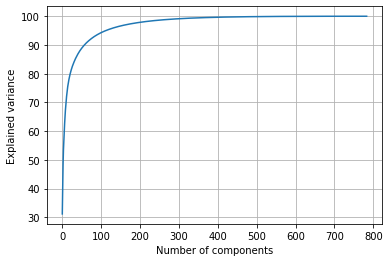

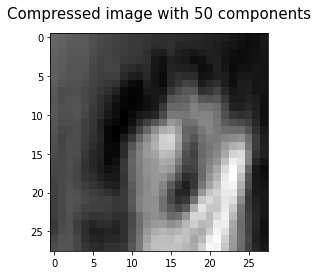

88.69898654718078
Final data sizes:  (27455, 50) (7172, 50) (27455,) (7172,)


In [ ]:
x_tr, x_te, y_tr, y_te = gen_training_set(PCA_COMPONENTS=50, FILTER_NAME='', FOR_CNN=False)

train_score:  1.0
test_score:  0.8325432236475181
Test F1 score:  0.819672834262286
Test Accuracy:  0.8325432236475181


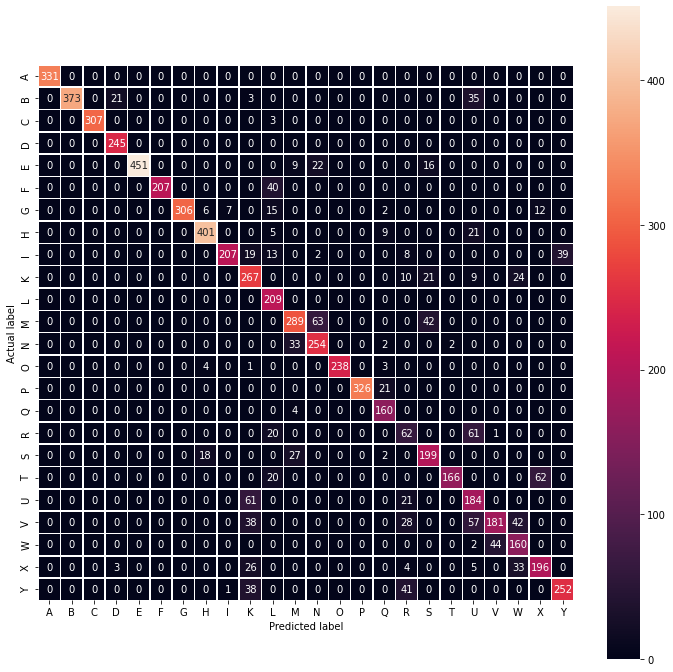

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       1.00      0.86      0.93       432
           2       1.00      0.99      1.00       310
           3       0.91      1.00      0.95       245
           4       1.00      0.91      0.95       498
           5       1.00      0.84      0.91       247
           6       1.00      0.88      0.94       348
           7       0.93      0.92      0.93       436
           8       0.96      0.72      0.82       288
          10       0.59      0.81      0.68       331
          11       0.64      1.00      0.78       209
          12       0.80      0.73      0.76       394
          13       0.74      0.87      0.80       291
          14       1.00      0.97      0.98       246
          15       1.00      0.94      0.97       347
          16       0.80      0.98      0.88       164
          17       0.36      0.43      0.39       144
          18       0.72    

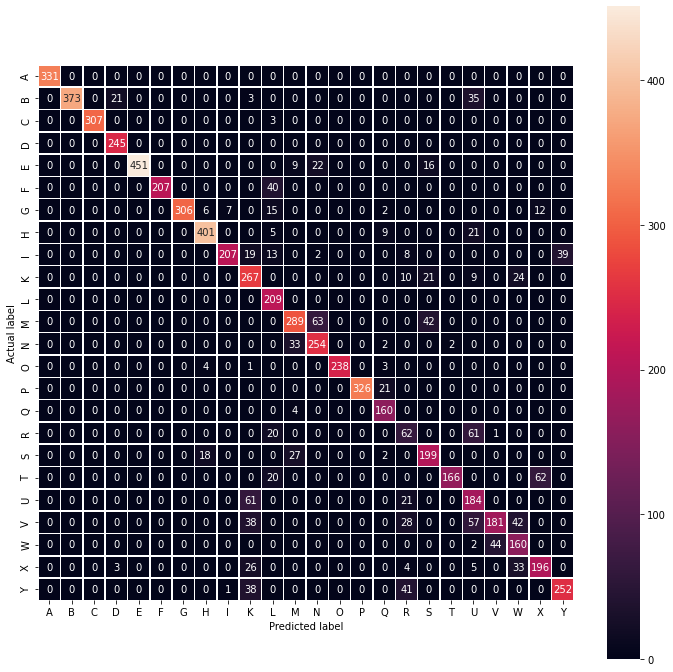

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       1.00      0.86      0.93       432
           2       1.00      0.99      1.00       310
           3       0.91      1.00      0.95       245
           4       1.00      0.91      0.95       498
           5       1.00      0.84      0.91       247
           6       1.00      0.88      0.94       348
           7       0.93      0.92      0.93       436
           8       0.96      0.72      0.82       288
          10       0.59      0.81      0.68       331
          11       0.64      1.00      0.78       209
          12       0.80      0.73      0.76       394
          13       0.74      0.87      0.80       291
          14       1.00      0.97      0.98       246
          15       1.00      0.94      0.97       347
          16       0.80      0.98      0.88       164
          17       0.36      0.43      0.39       144
          18       0.72    

In [ ]:
clf = SVC(kernel='rbf')

# metrics_svm = train_classifier(clf, x_tr, y_tr, x_te, y_te, tuning=True, search_type='random', RANDSEARCH_N_ITER=10)
metrics_svm = train_classifier(clf, x_tr, y_tr, x_te, y_te, tuning=True, search_type='grid')

### MLP

In [ ]:
x_tr, x_te, y_tr, y_te = gen_training_set(PCA_COMPONENTS=-1, FILTER_NAME='', FOR_CNN=False)

Final data sizes:  (27455, 784) (7172, 784) (27455,) (7172,)


Iteration 1, loss = 2.63507373
Validation score: 0.434086
Iteration 2, loss = 1.85590130
Validation score: 0.541515
Iteration 3, loss = 1.49394494
Validation score: 0.637291
Iteration 4, loss = 1.28790465
Validation score: 0.663146
Iteration 5, loss = 1.13060915
Validation score: 0.693008
Iteration 6, loss = 1.01719070
Validation score: 0.747997
Iteration 7, loss = 0.92298930
Validation score: 0.753824
Iteration 8, loss = 0.83954619
Validation score: 0.790240
Iteration 9, loss = 0.77091810
Validation score: 0.815732
Iteration 10, loss = 0.71370011
Validation score: 0.830663
Iteration 11, loss = 0.66462251
Validation score: 0.847414
Iteration 12, loss = 0.62097190
Validation score: 0.843773
Iteration 13, loss = 0.57517387
Validation score: 0.852149
Iteration 14, loss = 0.53491551
Validation score: 0.863802
Iteration 15, loss = 0.49799780
Validation score: 0.891114
Iteration 16, loss = 0.46836837
Validation score: 0.896577
Iteration 17, loss = 0.43942951
Validation score: 0.888929
Iterat

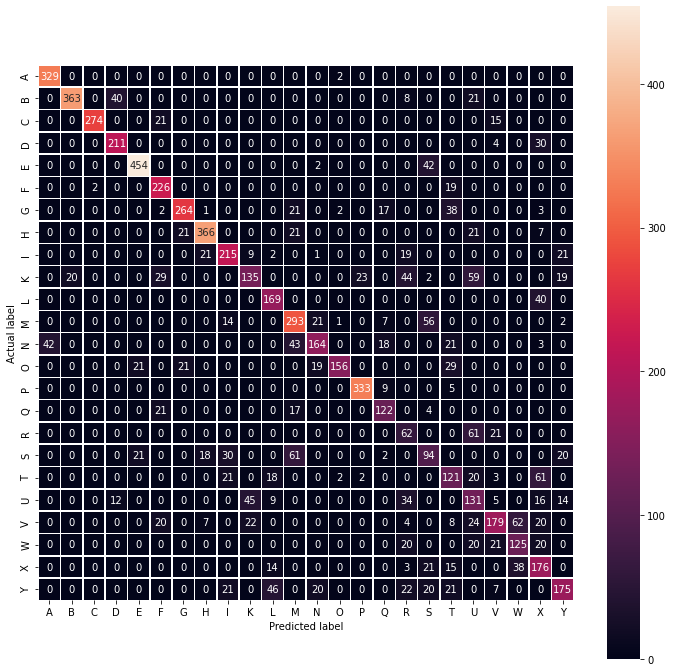

              precision    recall  f1-score   support

           0       0.89      0.99      0.94       331
           1       0.95      0.84      0.89       432
           2       0.99      0.88      0.94       310
           3       0.80      0.86      0.83       245
           4       0.92      0.91      0.91       498
           5       0.71      0.91      0.80       247
           6       0.86      0.76      0.81       348
           7       0.89      0.84      0.86       436
           8       0.71      0.75      0.73       288
          10       0.64      0.41      0.50       331
          11       0.66      0.81      0.72       209
          12       0.64      0.74      0.69       394
          13       0.72      0.56      0.63       291
          14       0.96      0.63      0.76       246
          15       0.93      0.96      0.94       347
          16       0.70      0.74      0.72       164
          17       0.29      0.43      0.34       144
          18       0.39    

In [ ]:
clf = MLPClassifier(random_state=1, 
                    verbose=True, 
                    early_stopping=True, 
                    validation_fraction=0.1,
                    solver='adam', 
                    learning_rate_init=0.001)

metrics_mlp = train_classifier(clf, x_tr, y_tr, x_te, y_te, tuning=False)

train_score:  0.9995993443817155
test_score:  0.7162576687116564
Test F1 score:  0.6922716759177465
Test Accuracy:  0.7162576687116564


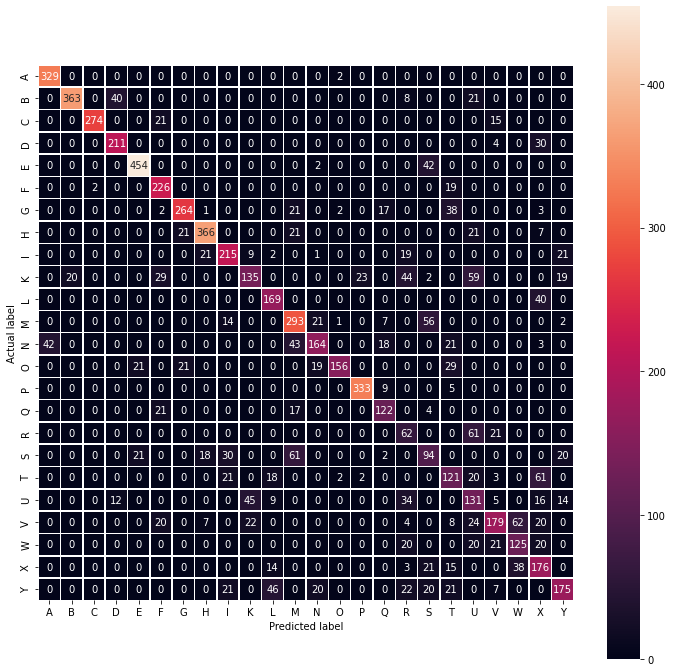

              precision    recall  f1-score   support

           0       0.89      0.99      0.94       331
           1       0.95      0.84      0.89       432
           2       0.99      0.88      0.94       310
           3       0.80      0.86      0.83       245
           4       0.92      0.91      0.91       498
           5       0.71      0.91      0.80       247
           6       0.86      0.76      0.81       348
           7       0.89      0.84      0.86       436
           8       0.71      0.75      0.73       288
          10       0.64      0.41      0.50       331
          11       0.66      0.81      0.72       209
          12       0.64      0.74      0.69       394
          13       0.72      0.56      0.63       291
          14       0.96      0.63      0.76       246
          15       0.93      0.96      0.94       347
          16       0.70      0.74      0.72       164
          17       0.29      0.43      0.34       144
          18       0.39    

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/3] END activation=logistic, batch_size=32, early_stopping=True, hidden_layer_sizes=64, learning_rate_init=0.0001, solver=adam;, score=0.998 total time= 3.7min


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/3] END activation=logistic, batch_size=32, early_stopping=True, hidden_layer_sizes=64, learning_rate_init=0.0001, solver=adam;, score=0.999 total time= 3.7min
[CV 3/3] END activation=logistic, batch_size=32, early_stopping=True, hidden_layer_sizes=64, learning_rate_init=0.0001, solver=adam;, score=1.000 total time= 3.8min
[CV 1/3] END activation=logistic, batch_size=16, early_stopping=True, hidden_layer_sizes=8, learning_rate_init=0.001, solver=adam;, score=0.978 total time= 1.2min
[CV 2/3] END activation=logistic, batch_size=16, early_stopping=True, hidden_layer_sizes=8, learning_rate_init=0.001, solver=adam;, score=0.953 total time=  53.6s
[CV 3/3] END activation=logistic, batch_size=16, early_stopping=True, hidden_layer_sizes=8, learning_rate_init=0.001, solver=adam;, score=0.978 total time= 1.2min
[CV 1/3] END activation=logistic, batch_size=32, early_stopping=True, hidden_layer_sizes=[16, 8], learning_rate_init=0.01, solver=adam;, score=0.080 total time=  25.1s
[CV 2/3] END 

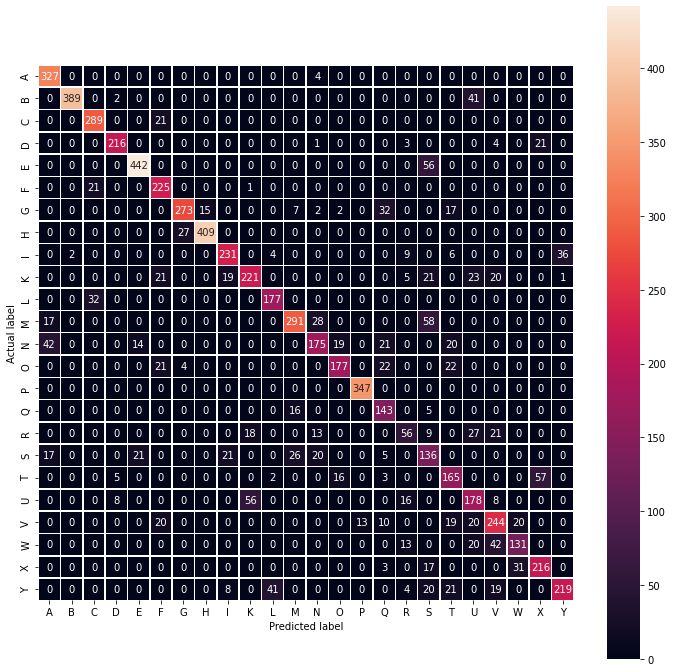

              precision    recall  f1-score   support

           0       0.81      0.99      0.89       331
           1       0.99      0.90      0.95       432
           2       0.85      0.93      0.89       310
           3       0.94      0.88      0.91       245
           4       0.93      0.89      0.91       498
           5       0.73      0.91      0.81       247
           6       0.90      0.78      0.84       348
           7       0.96      0.94      0.95       436
           8       0.83      0.80      0.81       288
          10       0.75      0.67      0.70       331
          11       0.79      0.85      0.82       209
          12       0.86      0.74      0.79       394
          13       0.72      0.60      0.66       291
          14       0.83      0.72      0.77       246
          15       0.96      1.00      0.98       347
          16       0.60      0.87      0.71       164
          17       0.53      0.39      0.45       144
          18       0.42    

In [ ]:
clf = MLPClassifier(random_state=1, early_stopping=True)

parameters_mlp_different = {
        'hidden_layer_sizes': [
                            [128, 64, 32, 16, 8], 
                            [128, 64, 32, 16], 
                            [32, 16, 8], 
                            [128, 64],
                            [128, 64, 32], 
                            [256, 128],
                            [64, 32],
                            [32, 32],
                            [32, 16], 
                            [8, 8], 
                            [16, 16],
                            [16, 8],
                            [8, 4],
                            8, 16, 32, 64, 128, 256
                            ], 
        'activation': ['logistic', 'relu'],
        'solver': ['adam'],
        'learning_rate_init': [0.01, 0.001, 0.0001],
        'batch_size': [16, 32],
        'early_stopping':[True]
    }

metrics_mlp = train_classifier(clf, x_tr, y_tr, x_te, y_te, tuning=True, search_type='random', RANDSEARCH_N_ITER=10, parameters=parameters_mlp_different)

###CNN

In [ ]:
x_tr, x_te, y_tr, y_te = gen_training_set(PCA_COMPONENTS=-1, FILTER_NAME='', FOR_CNN=True)

Final data sizes:  (27455, 28, 28, 1) (7172, 28, 28, 1) (27455,) (7172,)


(24709, 28, 28, 1) (2746, 28, 28, 1)
Data aug samples:


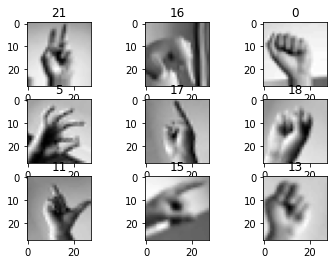

24709


  0%|          | 0/24709 [00:00<?, ?it/s]

Augmented final sizes: (49418, 784) (49418,)
(49418, 28, 28, 1) (2746, 28, 28, 1)
tr class dist


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


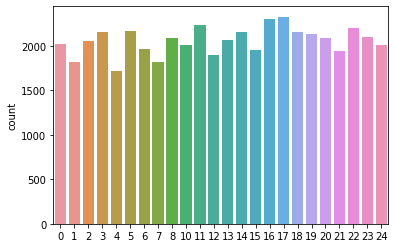

val class dist


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


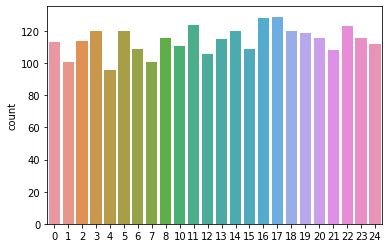

In [ ]:
x_tr, x_val, y_tr, y_val = train_test_split(x_tr, y_tr, stratify=y_tr, test_size=0.1)

print(x_tr.shape, x_val.shape)

# augment training data
x_tr, y_tr = data_aug(x_tr, y_tr, aug_factor=1)

x_tr = x_tr.reshape(-1,28,28,1)
x_val = x_val.reshape(-1,28,28,1)


# train and validation sizes
print(x_tr.shape, x_val.shape)

print('tr class dist')
sns.countplot(y_tr)
plt.show()

print('val class dist')
sns.countplot(y_val)
plt.show()


In [ ]:
def build_model(hp):
    input_shape = x_tr.shape[1:]
    
    model = Sequential()

    mp = 0

    for i in range(hp.Int('conv_layers', 2, 4)):
        if i == 0:
            model.add(                    
                Conv2D( filters=hp.Int(f'f_{i}', min_value=64, max_value=128, step=32),
                    kernel_size=(3,3),
                    activation="relu", 
                    input_shape=input_shape )
            )
        else:
            model.add(                    
                Conv2D( filters=hp.Int(f'f_{i}', min_value=64, max_value=128, step=32),
                    kernel_size=(3,3),
                    activation="relu" )
            )

        if hp.Boolean(f'batchnorm_{i}'):
            model.add(BatchNormalization())

        if hp.Boolean(f'maxpool_{i}') and mp < 2:
            model.add(MaxPooling2D(pool_size=(2,2)))
            mp += 1


    model.add(Flatten())
    
    if hp.Boolean(f'flatten_batchnorm'):
        model.add(BatchNormalization())
    
    model.add(
        Dense(
            units = hp.Int("units", min_value=64, max_value=256, step=32), 
            activation="relu"
        )
    )

    if hp.Boolean(f'final_batchnorm'):
        model.add(BatchNormalization())
    
    model.add(Dense(25, activation="softmax"))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'],
    )
    
    return model

In [ ]:
tuner = kt.Hyperband( 
    build_model, 
    objective='val_accuracy', 
    max_epochs=10,
    directory='cnn', 
    project_name='asl',
    overwrite=False
  )

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(
    x_tr, 
    y_tr, 
    epochs=30, 
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[stop_early]
  )

INFO:tensorflow:Reloading Oracle from existing project cnn/asl/oracle.json
INFO:tensorflow:Reloading Tuner from cnn/asl/tuner0.json
INFO:tensorflow:Oracle triggered exit


In [ ]:
print(tuner.search_space_summary())

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps)

Search space summary
Default search space size: 17
conv_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': None}
f_0 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 128, 'step': 32, 'sampling': None}
batchnorm_0 (Boolean)
{'default': False, 'conditions': []}
maxpool_0 (Boolean)
{'default': False, 'conditions': []}
f_1 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 128, 'step': 32, 'sampling': None}
batchnorm_1 (Boolean)
{'default': False, 'conditions': []}
maxpool_1 (Boolean)
{'default': False, 'conditions': []}
flatten_batchnorm (Boolean)
{'default': False, 'conditions': []}
units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 32, 'sampling': None}
final_batchnorm (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
f_2 (Int)
{'defau

In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_tr, y_tr, epochs=30, validation_data=(x_val, y_val))

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))


Epoch 1/30
1545/1545 [==============================] - 9s 5ms/step - loss: 0.7698 - accuracy: 0.7845 - val_loss: 0.3178 - val_accuracy: 0.9071
Epoch 2/30
1545/1545 [==============================] - 8s 5ms/step - loss: 0.1938 - accuracy: 0.9464 - val_loss: 0.1660 - val_accuracy: 0.9534
Epoch 3/30
1545/1545 [==============================] - 8s 5ms/step - loss: 0.0932 - accuracy: 0.9751 - val_loss: 0.1206 - val_accuracy: 0.9616
Epoch 4/30
1545/1545 [==============================] - 8s 5ms/step - loss: 0.0570 - accuracy: 0.9853 - val_loss: 0.1214 - val_accuracy: 0.9650
Epoch 5/30
1545/1545 [==============================] - 8s 5ms/step - loss: 0.0399 - accuracy: 0.9895 - val_loss: 0.0907 - val_accuracy: 0.9714
Epoch 6/30
1545/1545 [==============================] - 7s 5ms/step - loss: 0.0358 - accuracy: 0.9901 - val_loss: 0.0888 - val_accuracy: 0.9707
Epoch 7/30
1545/1545 [==============================] - 8s 5ms/step - loss: 0.0279 - accuracy: 0.9922 - val_loss: 0.1149 - val_accuracy:

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 26, 26, 96)        960       
                                                                 
 batch_normalization_19 (Bat  (None, 26, 26, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 13, 13, 96)       0         
 2D)                                                             
                                                                 
 conv2d_27 (Conv2D)          (None, 11, 11, 96)        83040     
                                                                 
 batch_normalization_20 (Bat  (None, 11, 11, 96)       384       
 chNormalization)                                                
                                                     

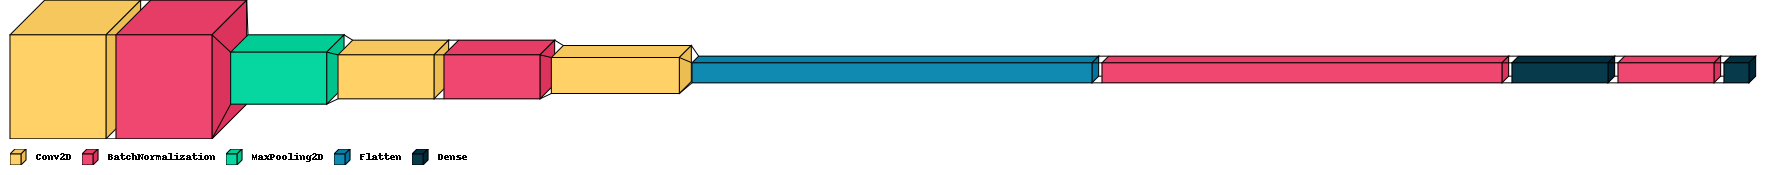

In [ ]:
visualkeras.layered_view(model, scale_z=1, legend=True)

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

history = hypermodel.fit(x_tr, y_tr, epochs=best_epoch, validation_data=(x_val, y_val))

Epoch 1/30
2780/2780 [==============================] - 15s 5ms/step - loss: 0.7834 - accuracy: 0.7744 - val_loss: 0.2011 - val_accuracy: 0.9476
Epoch 2/30
2780/2780 [==============================] - 15s 5ms/step - loss: 0.1923 - accuracy: 0.9452 - val_loss: 0.0685 - val_accuracy: 0.9822
Epoch 3/30
2780/2780 [==============================] - 14s 5ms/step - loss: 0.1023 - accuracy: 0.9708 - val_loss: 0.0585 - val_accuracy: 0.9844
Epoch 4/30
2780/2780 [==============================] - 14s 5ms/step - loss: 0.0696 - accuracy: 0.9794 - val_loss: 0.0441 - val_accuracy: 0.9870
Epoch 5/30
2780/2780 [==============================] - 14s 5ms/step - loss: 0.0488 - accuracy: 0.9852 - val_loss: 0.0340 - val_accuracy: 0.9905
Epoch 6/30
2780/2780 [==============================] - 15s 5ms/step - loss: 0.0397 - accuracy: 0.9884 - val_loss: 0.0178 - val_accuracy: 0.9947
Epoch 7/30
2780/2780 [==============================] - 14s 5ms/step - loss: 0.0358 - accuracy: 0.9887 - val_loss: 0.0198 - val_ac

In [ ]:
hypermodel.save('sign-lang-cnn.keras')

In [ ]:
# !zip -r cnn.zip cnn

225/225 [==============================] - 1s 3ms/step - loss: 0.0284 - accuracy: 0.9905


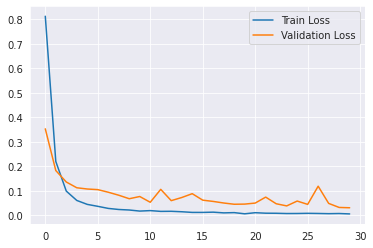

Train Loss:  0.005464799236506224
Test Loss:  0.028398508206009865
Test F1 score:  0.9902774840955133
Test Accuracy:  0.9905186837702176


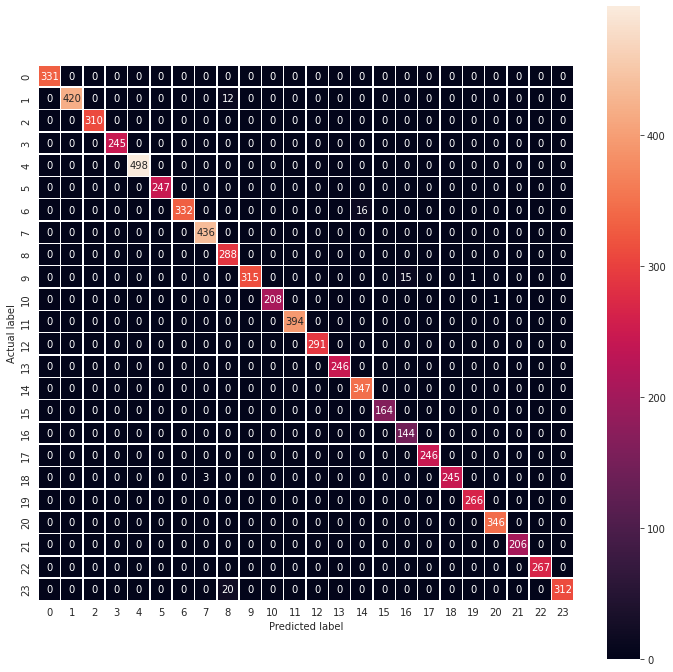

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       1.00      0.97      0.99       432
           2       1.00      1.00      1.00       310
           3       1.00      1.00      1.00       245
           4       1.00      1.00      1.00       498
           5       1.00      1.00      1.00       247
           6       1.00      0.95      0.98       348
           7       0.99      1.00      1.00       436
           8       0.90      1.00      0.95       288
          10       1.00      0.95      0.98       331
          11       1.00      1.00      1.00       209
          12       1.00      1.00      1.00       394
          13       1.00      1.00      1.00       291
          14       1.00      1.00      1.00       246
          15       0.96      1.00      0.98       347
          16       1.00      1.00      1.00       164
          17       0.91      1.00      0.95       144
          18       1.00    

In [ ]:
test_loss, test_accuracy = hypermodel.evaluate(x_te, y_te)

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

y_pred_prob = hypermodel.predict(x_te)
y_pred = np.argmax(y_pred_prob, axis=1)

# CLASSES = clf.classes_
CLASSES =  [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24 ]

cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels = CLASSES)
test_f1 = f1_score(y_true=y_test, y_pred=y_pred, average='macro')
test_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)

print("Train Loss: ", history.history['loss'][-1])
print("Test Loss: ", test_loss)

print("Test F1 score: ", test_f1)
print('Test Accuracy: ', test_accuracy)

plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True, linewidths=.5, square = True, fmt='');
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(y_test, y_pred))

# Keypoints Dataset

## Generate Keypoints Data from 200x200 image dataset

In [4]:
%%bash
if [ ! -d "asl_alphabet_train" ]
then
    echo '{"username":"zoraizq","key":"fc84a132b1366b775f79560a14cc911d"}' > kaggle.json
    cp "/content/kaggle.json" "/root/.kaggle/kaggle.json"
    chmod 600 /root/.kaggle/kaggle.json
    kaggle datasets download grassknoted/asl-alphabet
    unzip asl-alphabet.zip
else
    echo "Dataset folder already exists."
fi

if [ ! -d "asl_alphabet_train" ]
then
    echo '{"username":"zoraizq","key":"fc84a132b1366b775f79560a14cc911d"}' > kaggle.json
    cp "/content/kaggle.json" "/root/.kaggle/kaggle.json"
    chmod 600 /root/.kaggle/kaggle.json
    kaggle datasets download grassknoted/asl-alphabet
    unzip asl-alphabet.zip
else
    echo "Dataset folder already exists."
fi

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

cp: cannot create regular file '/root/.kaggle/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
unzip:  cannot find o

In [5]:
# higher res 200x200 image dataset, test
# x2 = []
# y2 = []

# root = 'asl_alphabet_train/asl_alphabet_train'
# for f in os.listdir(root):
#   if len(f) == 1:
#     letter = f
#     letter_folder = os.path.join(root, letter)
#     for img_f in os.listdir(letter_folder):
#       img_path = os.path.join(letter_folder, img_f)
#       img = cv2.imread(img_path)
#       img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#       lbl = ord(letter)-65
#       x2.append(img)
#       y2.append(lbl)
#       break

In [6]:
# !pip install mediapipe

In [7]:
# import mediapipe as mp
# mp_drawing = mp.solutions.drawing_utils
# mp_drawing_styles = mp.solutions.drawing_styles
# mp_hands = mp.solutions.hands

# x3 = []
# y3 = []

# with mp_hands.Hands( static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5) as hands:

#   for i in tqdm(range(len(x2))):
    
#     lbl = y2[i]
#     image = x2[i]
#     image = image.astype(np.uint8)
#     results = hands.process(image)

#     if not results.multi_hand_landmarks:
#       continue


#     keypoints = []
#     for j in range(21):
#       landmark = results.multi_hand_world_landmarks[0].landmark[j]
#       keypoints.append([landmark.x, landmark.y, landmark.z])
    
#     keypoints = np.array(keypoints)

#     if keypoints.shape[0] == 21:
#       x3.append(keypoints)
#       y3.append(lbl)

#     # annotated_image = image.copy()
#       # for hand_landmarks in results.multi_hand_landmarks:
#       #   mp_drawing.draw_landmarks(
#       #       annotated_image,
#       #       hand_landmarks,
#       #       mp_hands.HAND_CONNECTIONS,
#       #       mp_drawing_styles.get_default_hand_landmarks_style(),
#       #       mp_drawing_styles.get_default_hand_connections_style())
      
#       # plt.imshow(annotated_image)

#     # if not results.multi_hand_world_landmarks:
#     #   continue
#     # for hand_world_landmarks in results.multi_hand_world_landmarks:
#     #   mp_drawing.plot_landmarks(hand_world_landmarks, mp_hands.HAND_CONNECTIONS, azimuth=5)


In [8]:
# x3 = np.array(x3)
# y3 = np.array(y3)

# with open('keypoints_data.pkl', 'wb') as f:
#   pickle.dump([x3, y3], f)

In [9]:
# !cp keypoints_data.pkl drive/MyDrive/ML-ASL/keypoints_data.pkl

In [10]:
# from google.colab import drive
# drive.mount('/content/drive')

## Load Pre-Processed Keypoints data

In [11]:
%%bash
pip install gdown
pip install --upgrade gdown
gdown https://drive.google.com/uc?id=11_Buo4d8EzS7pYju6aPOSAOrEW9Q2gss

Downloading...
From: https://drive.google.com/uc?id=11_Buo4d8EzS7pYju6aPOSAOrEW9Q2gss
To: /content/keypoints_data.pkl
100%|██████████| 30.9M/30.9M [00:00<00:00, 248MB/s]


In [12]:
# keypoints_pkl_path = "drive/MyDrive/ML-ASL/keypoints_data.pkl" # no need to pre-process again, unless doing data augmentation
keypoints_pkl_path = "keypoints_data.pkl" # no need to pre-process again, unless doing data augmentation

with open(keypoints_pkl_path, 'rb') as f:
  [x3, y3] = pickle.load(f)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x3, y3, test_size=0.3, random_state=42)

x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(42242, 63) (42242,) (18105, 63) (18105,)


## Training

-0.10722842812538147 0.1448039561510086
0 25
tr class dist


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


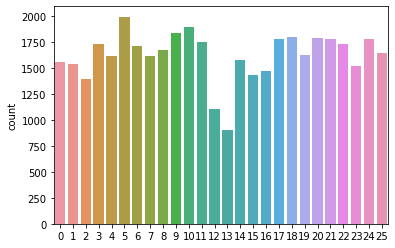

In [14]:
print(x_train.min(), x_train.max())
print(y_train.min(), y_train.max())

print('tr class dist')
sns.countplot(y_train)
plt.show()


### Logistic Regression

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    6.0s finished


train_score:  0.950215425405994
test_score:  0.9502899751449876
Test F1 score:  0.9463451632345772
Test Accuracy:  0.9502899751449876


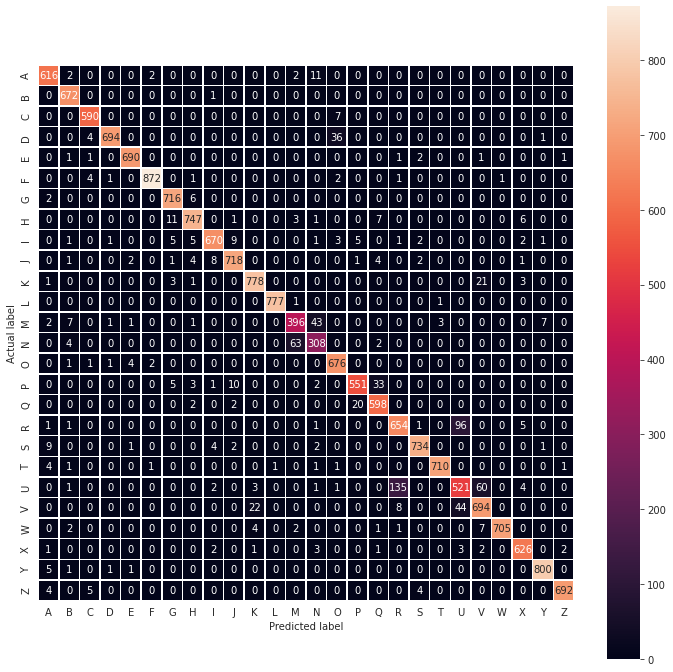

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       633
           1       0.97      1.00      0.98       673
           2       0.98      0.99      0.98       597
           3       0.99      0.94      0.97       735
           4       0.99      0.99      0.99       697
           5       0.99      0.99      0.99       882
           6       0.97      0.99      0.98       724
           7       0.97      0.96      0.97       776
           8       0.97      0.95      0.96       706
           9       0.97      0.97      0.97       742
          10       0.96      0.96      0.96       807
          11       1.00      1.00      1.00       779
          12       0.85      0.86      0.85       461
          13       0.82      0.82      0.82       377
          14       0.93      0.99      0.96       685
          15       0.95      0.91      0.93       605
          16       0.93      0.96      0.94       622
          17       0.82    

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   39.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 1/3] END C=80.0128598492615, penalty=l1, solver=saga;, score=0.983 total time=  39.2s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   39.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 2/3] END C=80.0128598492615, penalty=l1, solver=saga;, score=0.983 total time=  39.8s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   38.8s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 3/3] END C=80.0128598492615, penalty=l1, solver=saga;, score=0.980 total time=  38.9s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    4.5s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 1/3] END C=0.41312808904216114, penalty=l2, solver=saga;, score=0.929 total time=   4.7s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    3.8s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 2/3] END C=0.41312808904216114, penalty=l2, solver=saga;, score=0.923 total time=   3.9s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    4.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 3/3] END C=0.41312808904216114, penalty=l2, solver=saga;, score=0.925 total time=   4.1s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   40.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 1/3] END C=14.920507346906673, l1_ratio=0.7777777777777777, penalty=elasticnet, solver=saga;, score=0.978 total time=  40.2s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   40.2s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 2/3] END C=14.920507346906673, l1_ratio=0.7777777777777777, penalty=elasticnet, solver=saga;, score=0.977 total time=  40.3s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   39.4s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 3/3] END C=14.920507346906673, l1_ratio=0.7777777777777777, penalty=elasticnet, solver=saga;, score=0.974 total time=  39.5s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 1/3] END C=0.002220397918439394, l1_ratio=0.4444444444444444, penalty=elasticnet, solver=saga;, score=0.003 total time=   1.4s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 2/3] END C=0.002220397918439394, l1_ratio=0.4444444444444444, penalty=elasticnet, solver=saga;, score=0.003 total time=   1.5s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 3/3] END C=0.002220397918439394, l1_ratio=0.4444444444444444, penalty=elasticnet, solver=saga;, score=0.003 total time=   1.2s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    3.5s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 1/3] END C=1.3659139744990738, penalty=l2, solver=saga;, score=0.949 total time=   3.7s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    3.8s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 2/3] END C=1.3659139744990738, penalty=l2, solver=saga;, score=0.947 total time=   3.9s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 3/3] END C=1.3659139744990738, penalty=l2, solver=saga;, score=0.942 total time=   3.9s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    4.5s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 1/3] END C=0.009164026507938978, penalty=l1, solver=saga;, score=0.004 total time=   4.6s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    5.3s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 2/3] END C=0.009164026507938978, penalty=l1, solver=saga;, score=0.004 total time=   5.5s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    5.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 3/3] END C=0.009164026507938978, penalty=l1, solver=saga;, score=0.004 total time=   5.1s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   33.8s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 1/3] END C=1.0675490091576998, penalty=l1, solver=saga;, score=0.971 total time=  33.9s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   35.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 2/3] END C=1.0675490091576998, penalty=l1, solver=saga;, score=0.969 total time=  35.1s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   34.9s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 3/3] END C=1.0675490091576998, penalty=l1, solver=saga;, score=0.967 total time=  35.1s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 1/3] END C=0.0057490476983072854, penalty=l2, solver=lbfgs;, score=0.216 total time=   0.7s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 2/3] END C=0.0057490476983072854, penalty=l2, solver=lbfgs;, score=0.218 total time=   0.7s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    0.5s finished
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 3/3] END C=0.0057490476983072854, penalty=l2, solver=lbfgs;, score=0.219 total time=   0.7s
[CV 1/3] END C=0.8106641290601738, penalty=none, solver=newton-cg;, score=0.985 total time= 4.4min


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:  4.4min finished
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 2/3] END C=0.8106641290601738, penalty=none, solver=newton-cg;, score=0.985 total time= 4.4min


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:  4.4min finished
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 3/3] END C=0.8106641290601738, penalty=none, solver=newton-cg;, score=0.985 total time= 4.6min


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:  4.6min finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 1/3] END C=1.1445286878611698, penalty=l1, solver=saga;, score=0.972 total time=  34.7s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   34.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   34.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 2/3] END C=1.1445286878611698, penalty=l1, solver=saga;, score=0.970 total time=  34.7s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   34.9s finished
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 3/3] END C=1.1445286878611698, penalty=l1, solver=saga;, score=0.968 total time=  35.0s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    4.0s finished
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 1/3] END C=1.2999732764678253, penalty=none, solver=lbfgs;, score=0.974 total time=   4.1s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    4.0s finished
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 2/3] END C=1.2999732764678253, penalty=none, solver=lbfgs;, score=0.973 total time=   4.1s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    4.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 3/3] END C=1.2999732764678253, penalty=none, solver=lbfgs;, score=0.968 total time=   4.1s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 1/3] END C=0.00014856775745822386, l1_ratio=0.4444444444444444, penalty=elasticnet, solver=saga;, score=0.003 total time=   0.7s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 2/3] END C=0.00014856775745822386, l1_ratio=0.4444444444444444, penalty=elasticnet, solver=saga;, score=0.003 total time=   0.5s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 3/3] END C=0.00014856775745822386, l1_ratio=0.4444444444444444, penalty=elasticnet, solver=saga;, score=0.003 total time=   0.7s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 1/3] END C=0.0009208395001632423, penalty=l2, solver=newton-cg;, score=0.003 total time=   1.9s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 2/3] END C=0.0009208395001632423, penalty=l2, solver=newton-cg;, score=0.003 total time=   1.8s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 3/3] END C=0.0009208395001632423, penalty=l2, solver=newton-cg;, score=0.003 total time=   1.6s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    9.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 1/3] END C=12.64097878904309, penalty=l2, solver=saga;, score=0.966 total time=   9.9s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    9.9s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 2/3] END C=12.64097878904309, penalty=l2, solver=saga;, score=0.966 total time=  10.0s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   10.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 3/3] END C=12.64097878904309, penalty=l2, solver=saga;, score=0.963 total time=  10.1s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    4.9s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 1/3] END C=0.7374206451657234, penalty=l2, solver=newton-cg;, score=0.942 total time=   5.0s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    5.2s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 2/3] END C=0.7374206451657234, penalty=l2, solver=newton-cg;, score=0.937 total time=   5.3s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 3/3] END C=0.7374206451657234, penalty=l2, solver=newton-cg;, score=0.937 total time=   4.8s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    3.8s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 1/3] END C=33.12675655740419, penalty=l2, solver=lbfgs;, score=0.973 total time=   3.9s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    3.8s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 2/3] END C=33.12675655740419, penalty=l2, solver=lbfgs;, score=0.963 total time=   3.9s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    3.7s finished
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 3/3] END C=33.12675655740419, penalty=l2, solver=lbfgs;, score=0.965 total time=   3.8s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    3.8s finished
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 1/3] END C=23.74731251808309, penalty=none, solver=lbfgs;, score=0.974 total time=   3.9s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    3.7s finished
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 2/3] END C=23.74731251808309, penalty=none, solver=lbfgs;, score=0.973 total time=   3.8s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 3/3] END C=23.74731251808309, penalty=none, solver=lbfgs;, score=0.968 total time=   3.9s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 1/3] END C=1.409026560493347e-05, l1_ratio=0.0, penalty=elasticnet, solver=saga;, score=0.003 total time=   4.9s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    4.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 2/3] END C=1.409026560493347e-05, l1_ratio=0.0, penalty=elasticnet, solver=saga;, score=0.003 total time=   4.2s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    3.9s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 3/3] END C=1.409026560493347e-05, l1_ratio=0.0, penalty=elasticnet, solver=saga;, score=0.003 total time=   4.0s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 1/3] END C=0.01790101797267076, penalty=l2, solver=lbfgs;, score=0.398 total time=   1.0s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 2/3] END C=0.01790101797267076, penalty=l2, solver=lbfgs;, score=0.393 total time=   0.9s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 3/3] END C=0.01790101797267076, penalty=l2, solver=lbfgs;, score=0.394 total time=   1.0s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   18.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 1/3] END C=9.803466784374947, l1_ratio=0.3333333333333333, penalty=elasticnet, solver=saga;, score=0.968 total time=  18.2s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   17.8s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 2/3] END C=9.803466784374947, l1_ratio=0.3333333333333333, penalty=elasticnet, solver=saga;, score=0.967 total time=  17.9s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   18.1s finished
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV 3/3] END C=9.803466784374947, l1_ratio=0.3333333333333333, penalty=elasticnet, solver=saga;, score=0.964 total time=  18.2s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:  6.8min finished


best params {'C': 0.8106641290601738, 'penalty': 'none', 'solver': 'newton-cg'}
train_score:  0.9967049981333415
test_score:  0.9857722540626123
Test F1 score:  0.9857722540626123
Test Accuracy:  0.987903893951947


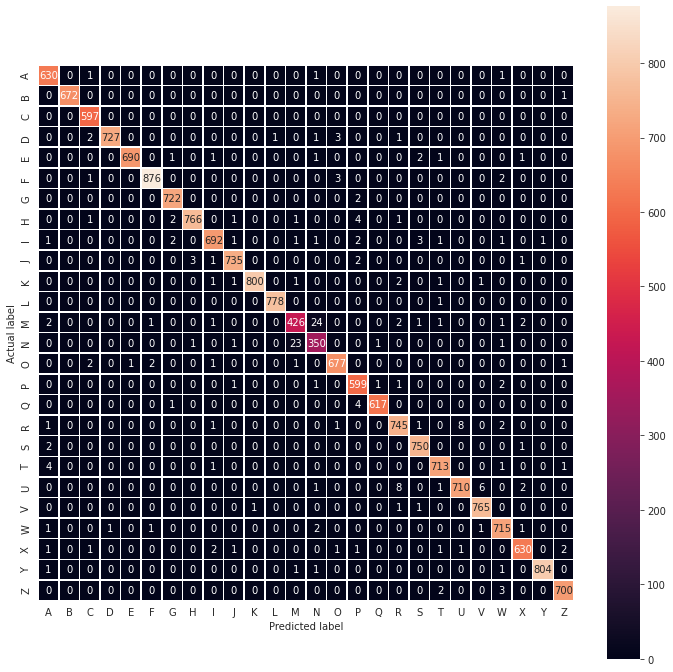

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       633
           1       1.00      1.00      1.00       673
           2       0.99      1.00      0.99       597
           3       1.00      0.99      0.99       735
           4       1.00      0.99      0.99       697
           5       1.00      0.99      0.99       882
           6       0.99      1.00      0.99       724
           7       0.99      0.99      0.99       776
           8       0.99      0.98      0.98       706
           9       0.99      0.99      0.99       742
          10       1.00      0.99      1.00       807
          11       1.00      1.00      1.00       779
          12       0.94      0.92      0.93       461
          13       0.91      0.93      0.92       377
          14       0.99      0.99      0.99       685
          15       0.98      0.99      0.98       605
          16       1.00      0.99      0.99       622
          17       0.98    

In [ ]:
clf = LogisticRegression(verbose=1,n_jobs=10)

metrics_lr = train_classifier(clf, x_train, y_train, x_test, y_test, tuning=True, search_type='random')

### SVM

train_score:  0.990246673926424
test_score:  0.9892847279756973
Test F1 score:  0.9873403977991534
Test Accuracy:  0.9892847279756973


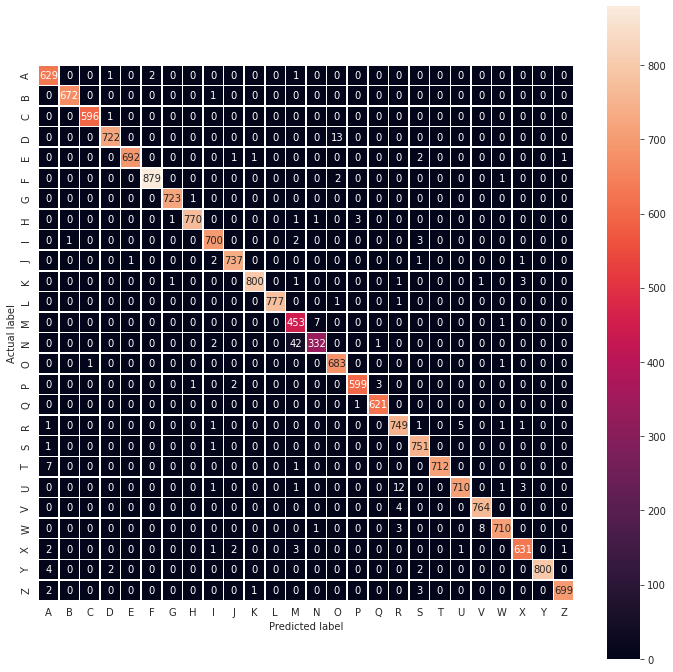

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       633
           1       1.00      1.00      1.00       673
           2       1.00      1.00      1.00       597
           3       0.99      0.98      0.99       735
           4       1.00      0.99      1.00       697
           5       1.00      1.00      1.00       882
           6       1.00      1.00      1.00       724
           7       1.00      0.99      0.99       776
           8       0.99      0.99      0.99       706
           9       0.99      0.99      0.99       742
          10       1.00      0.99      0.99       807
          11       1.00      1.00      1.00       779
          12       0.90      0.98      0.94       461
          13       0.97      0.88      0.92       377
          14       0.98      1.00      0.99       685
          15       0.99      0.99      0.99       605
          16       0.99      1.00      1.00       622
          17       0.97    

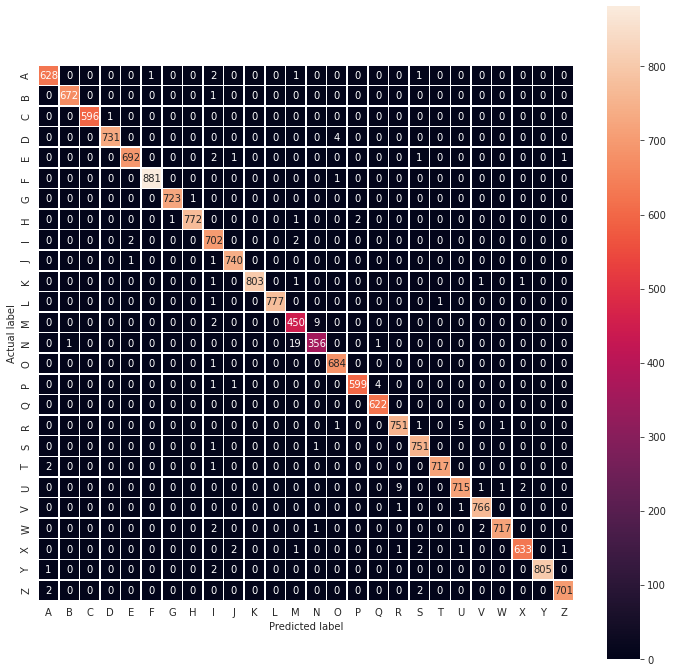

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       633
           1       1.00      1.00      1.00       673
           2       1.00      1.00      1.00       597
           3       1.00      0.99      1.00       735
           4       1.00      0.99      0.99       697
           5       1.00      1.00      1.00       882
           6       1.00      1.00      1.00       724
           7       1.00      0.99      1.00       776
           8       0.97      0.99      0.98       706
           9       0.99      1.00      1.00       742
          10       1.00      1.00      1.00       807
          11       1.00      1.00      1.00       779
          12       0.95      0.98      0.96       461
          13       0.97      0.94      0.96       377
          14       0.99      1.00      0.99       685
          15       1.00      0.99      0.99       605
          16       0.99      1.00      1.00       622
          17       0.99    

In [ ]:
clf = SVC()

metrics_svm = train_classifier(clf, x_train, y_train, x_test, y_test, tuning=True, search_type='random', RANDSEARCH_N_ITER=10)

train_score:  0.9973959566308414
test_score:  0.9933167633250484
Test F1 score:  0.9921510208847739
Test Accuracy:  0.9933167633250484


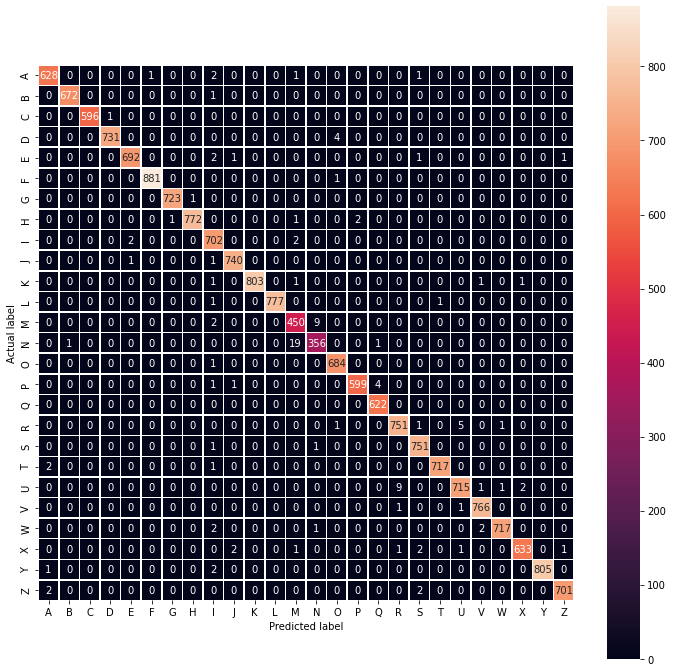

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       633
           1       1.00      1.00      1.00       673
           2       1.00      1.00      1.00       597
           3       1.00      0.99      1.00       735
           4       1.00      0.99      0.99       697
           5       1.00      1.00      1.00       882
           6       1.00      1.00      1.00       724
           7       1.00      0.99      1.00       776
           8       0.97      0.99      0.98       706
           9       0.99      1.00      1.00       742
          10       1.00      1.00      1.00       807
          11       1.00      1.00      1.00       779
          12       0.95      0.98      0.96       461
          13       0.97      0.94      0.96       377
          14       0.99      1.00      0.99       685
          15       1.00      0.99      0.99       605
          16       0.99      1.00      1.00       622
          17       0.99    

In [19]:
clf = SVC(kernel='rbf', gamma=100.0, C=1.0)

metrics_svm = train_classifier(clf, x_train, y_train, x_test, y_test, tuning=False)

In [21]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))


The scikit-learn version is 1.0.2.


### MLP

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


train_score:  0.9946735476539936
test_score:  0.9905550952775476
Test F1 score:  0.9891336260850104
Test Accuracy:  0.9905550952775476


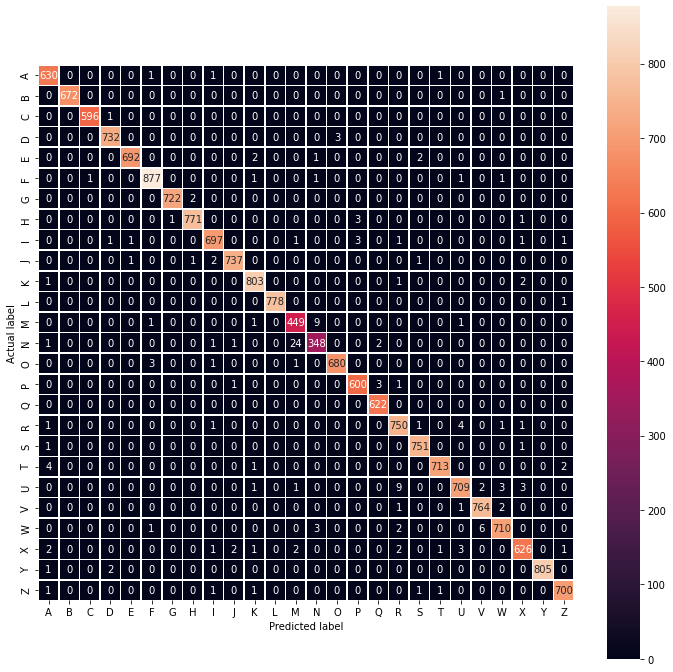

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       633
           1       1.00      1.00      1.00       673
           2       1.00      1.00      1.00       597
           3       0.99      1.00      1.00       735
           4       1.00      0.99      0.99       697
           5       0.99      0.99      0.99       882
           6       1.00      1.00      1.00       724
           7       1.00      0.99      0.99       776
           8       0.99      0.99      0.99       706
           9       0.99      0.99      0.99       742
          10       0.99      1.00      0.99       807
          11       1.00      1.00      1.00       779
          12       0.94      0.97      0.96       461
          13       0.96      0.92      0.94       377
          14       1.00      0.99      0.99       685
          15       0.99      0.99      0.99       605
          16       0.99      1.00      1.00       622
          17       0.98    

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/3] END activation=tanh, batch_size=64, hidden_layer_sizes=[128, 64], learning_rate_init=0.001, max_iter=100, solver=sgd;, score=0.941 total time= 1.3min


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/3] END activation=tanh, batch_size=64, hidden_layer_sizes=[128, 64], learning_rate_init=0.001, max_iter=100, solver=sgd;, score=0.938 total time= 1.3min


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/3] END activation=tanh, batch_size=64, hidden_layer_sizes=[128, 64], learning_rate_init=0.001, max_iter=100, solver=sgd;, score=0.935 total time= 1.3min


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/3] END activation=tanh, batch_size=32, hidden_layer_sizes=[128, 64], learning_rate_init=0.001, max_iter=50, solver=sgd;, score=0.939 total time=  32.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/3] END activation=tanh, batch_size=32, hidden_layer_sizes=[128, 64], learning_rate_init=0.001, max_iter=50, solver=sgd;, score=0.938 total time=  32.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/3] END activation=tanh, batch_size=32, hidden_layer_sizes=[128, 64], learning_rate_init=0.001, max_iter=50, solver=sgd;, score=0.933 total time=  32.2s
[CV 1/3] END activation=logistic, batch_size=64, hidden_layer_sizes=[32, 16], learning_rate_init=0.1, max_iter=250, solver=sgd;, score=0.973 total time=  22.9s
[CV 2/3] END activation=logistic, batch_size=64, hidden_layer_sizes=[32, 16], learning_rate_init=0.1, max_iter=250, solver=sgd;, score=0.968 total time=  30.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/3] END activation=logistic, batch_size=64, hidden_layer_sizes=[32, 16], learning_rate_init=0.1, max_iter=250, solver=sgd;, score=0.979 total time=  56.0s
[CV 1/3] END activation=logistic, batch_size=32, hidden_layer_sizes=[64, 32], learning_rate_init=1.0, max_iter=100, solver=sgd;, score=0.978 total time=  25.6s
[CV 2/3] END activation=logistic, batch_size=32, hidden_layer_sizes=[64, 32], learning_rate_init=1.0, max_iter=100, solver=sgd;, score=0.941 total time=  10.6s
[CV 3/3] END activation=logistic, batch_size=32, hidden_layer_sizes=[64, 32], learning_rate_init=1.0, max_iter=100, solver=sgd;, score=0.953 total time=  20.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/3] END activation=relu, batch_size=64, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=250, solver=sgd;, score=0.919 total time=  43.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/3] END activation=relu, batch_size=64, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=250, solver=sgd;, score=0.916 total time=  43.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/3] END activation=relu, batch_size=64, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=250, solver=sgd;, score=0.914 total time=  43.4s
[CV 1/3] END activation=tanh, batch_size=32, hidden_layer_sizes=256, learning_rate_init=1.0, max_iter=100, solver=sgd;, score=0.002 total time=  16.7s
[CV 2/3] END activation=tanh, batch_size=32, hidden_layer_sizes=256, learning_rate_init=1.0, max_iter=100, solver=sgd;, score=0.003 total time=  17.2s
[CV 3/3] END activation=tanh, batch_size=32, hidden_layer_sizes=256, learning_rate_init=1.0, max_iter=100, solver=sgd;, score=0.003 total time=  17.1s
[CV 1/3] END activation=tanh, batch_size=16, hidden_layer_sizes=[32, 16], learning_rate_init=0.1, max_iter=500, solver=sgd;, score=0.955 total time=  36.7s
[CV 2/3] END activation=tanh, batch_size=16, hidden_layer_sizes=[32, 16], learning_rate_init=0.1, max_iter=500, solver=sgd;, score=0.960 total time=  14.2s
[CV 3/3] END activation=tanh, batch_size=16, hidden_layer_sizes=[32, 16], learning_

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/3] END activation=relu, batch_size=64, hidden_layer_sizes=256, learning_rate_init=0.01, max_iter=50, solver=adam;, score=0.992 total time= 1.0min


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/3] END activation=relu, batch_size=64, hidden_layer_sizes=256, learning_rate_init=0.01, max_iter=50, solver=adam;, score=0.990 total time= 1.0min


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/3] END activation=relu, batch_size=64, hidden_layer_sizes=256, learning_rate_init=0.01, max_iter=50, solver=adam;, score=0.988 total time= 1.0min


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/3] END activation=tanh, batch_size=64, hidden_layer_sizes=64, learning_rate_init=0.0001, max_iter=250, solver=adam;, score=0.979 total time= 1.1min


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/3] END activation=tanh, batch_size=64, hidden_layer_sizes=64, learning_rate_init=0.0001, max_iter=250, solver=adam;, score=0.980 total time= 1.1min


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/3] END activation=tanh, batch_size=64, hidden_layer_sizes=64, learning_rate_init=0.0001, max_iter=250, solver=adam;, score=0.974 total time= 1.1min
[CV 1/3] END activation=tanh, batch_size=64, hidden_layer_sizes=128, learning_rate_init=1.0, max_iter=50, solver=adam;, score=0.886 total time=  15.1s
[CV 2/3] END activation=tanh, batch_size=64, hidden_layer_sizes=128, learning_rate_init=1.0, max_iter=50, solver=adam;, score=0.837 total time=  14.0s
[CV 3/3] END activation=tanh, batch_size=64, hidden_layer_sizes=128, learning_rate_init=1.0, max_iter=50, solver=adam;, score=0.864 total time=  14.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/3] END activation=relu, batch_size=64, hidden_layer_sizes=[128, 64, 32, 16], learning_rate_init=0.001, max_iter=100, solver=adam;, score=0.989 total time= 3.5min


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/3] END activation=relu, batch_size=64, hidden_layer_sizes=[128, 64, 32, 16], learning_rate_init=0.001, max_iter=100, solver=adam;, score=0.980 total time= 3.4min


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/3] END activation=relu, batch_size=64, hidden_layer_sizes=[128, 64, 32, 16], learning_rate_init=0.001, max_iter=100, solver=adam;, score=0.985 total time= 3.4min
[CV 1/3] END activation=relu, batch_size=16, hidden_layer_sizes=[128, 64], learning_rate_init=1.0, max_iter=50, solver=sgd;, score=0.003 total time=  14.5s
[CV 2/3] END activation=relu, batch_size=16, hidden_layer_sizes=[128, 64], learning_rate_init=1.0, max_iter=50, solver=sgd;, score=0.003 total time=  17.3s
[CV 3/3] END activation=relu, batch_size=16, hidden_layer_sizes=[128, 64], learning_rate_init=1.0, max_iter=50, solver=sgd;, score=0.003 total time=  20.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


best params {'solver': 'adam', 'max_iter': 50, 'learning_rate_init': 0.01, 'hidden_layer_sizes': 256, 'batch_size': 64, 'activation': 'relu'}
train_score:  0.9964506957048075
test_score:  0.9906369040456221
Test F1 score:  0.9906369040456221
Test Accuracy:  0.991935929301298


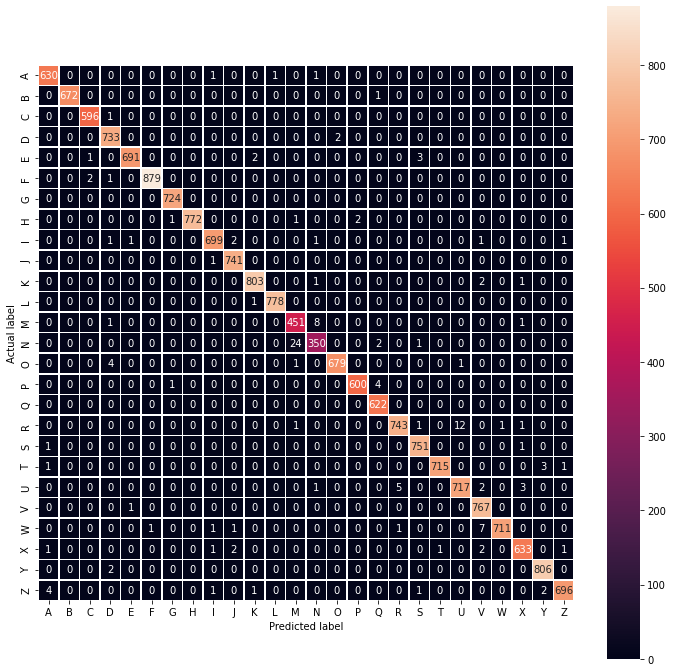

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       633
           1       1.00      1.00      1.00       673
           2       0.99      1.00      1.00       597
           3       0.99      1.00      0.99       735
           4       1.00      0.99      0.99       697
           5       1.00      1.00      1.00       882
           6       1.00      1.00      1.00       724
           7       1.00      0.99      1.00       776
           8       0.99      0.99      0.99       706
           9       0.99      1.00      1.00       742
          10       1.00      1.00      1.00       807
          11       1.00      1.00      1.00       779
          12       0.94      0.98      0.96       461
          13       0.97      0.93      0.95       377
          14       1.00      0.99      0.99       685
          15       1.00      0.99      0.99       605
          16       0.99      1.00      0.99       622
          17       0.99    

In [ ]:
clf = MLPClassifier(random_state=1)

metrics_mlp = train_classifier(clf, x_train, y_train, x_test, y_test, tuning=True, search_type='random')